In [1]:
!pip3 install sklearn
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.model_selection import learning_curve
#from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import os
import re
import csv
import glob

In [3]:
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|※|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|：|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

data kakunou

In [4]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
#target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1740, 4)


,media_name,label,title,sentence
649,dokujo-tsushin,0,独女たちの名言集feat.ニーチ,今年1月に発売してから、現在50万部突破のベストセラー本超訳ニーチェの言葉白取春彦編訳ディス...
522,dokujo-tsushin,0,梅村ゆずの結婚どころじゃないんですっ！vol.3Presentedbyゆるっとcaf,こんにちは。ちょっとした運動で、４日は筋肉痛になってしまう独身エロ漫画家、梅村ゆず33です。...
1712,it-life-hack,1,来たぜ！お祭り第3弾！GIGABYTE板祭でZ77マザーのレビューアーを大募,ソーシャルレビューコミュニティzigsowジグソーは、GIGABYTE板祭Returnsの第...
1219,it-life-hack,1,フリップカバーにスタンド＆バッテリーまで内蔵！GALAXYSIII専用ケースイケショップのレア,2012年今夏の最強スマートフォンとの呼び声を欲しいままにしているのがドコモのGALAXYS...
886,it-life-hack,1,Webで認知症チェックができる！日本初の認知機能チェックサービス脳測正式公,株式会社シグナルトークは、認知機能をチェック管理できるWebサービス脳測のうそくの正式サービ...
493,dokujo-tsushin,0,自転車女子、はじめましたvol.01Presentedbyゆるっとcaf,自転車には興味はあれど、さてどうしようかとお悩みの独女の皆様。まったく興味はないけど、北条晶...
956,it-life-hack,1,ハードルが高いダブルすれちがいドラクエXですれちがいは盛り上がるか?デジ,2009年に発売されたニンテンドーDS用ソフトのドラクエは、DSのすれちがい通信機能で宝の地...
1515,it-life-hack,1,iPhone、iPodの音質が劇的改善！FANTABITで音楽に革命をデジ,iOSiPhone、iPad、iPodtouch用の音楽アプリで有料にも関わらず大人気のもの...
1287,it-life-hack,1,Wordで何行書いたかひと目でわかるようにする方法知っ得虎の,Wordで長文を作成している場合、総行数を知りたいことがある。とはいえ、１ページに入っている...
537,dokujo-tsushin,0,がむしゃらに婚活しなくても幸せになれる！？まずは趣味,美枝さんIT関係37歳は婚活ブームの初期の頃、同僚に誘われて大人数制の婚活パーティーに何度か...


In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

In [7]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  あなたはどんな人物？何を目指している？あなたにとって一番大切なものは何？庶民でありながらも成績優秀で大学を卒業し、エリートコースまっしぐらの生活を送るため、ゴールドマンサックスの面接にやってきたアニースカーレットヨハンソン。簡単な質問だわと答えるも、言葉が出てこない。母親の期待に応えるため、ひたすら勝ち組になるために頑張って来たアニーにとって、エリートコースはあくまでも母が決めた道。自分のことが、分からない！！なんとなく大学に行き、なんとなく就職し、なんとなく年を取ってしまった。自分を見失う瞬間は、誰にでも必ずあるもの。アニーのように初めは20代でやってくるのかもしれない。でもきっと、30代、40代、50代になっても、同じように立ち止まる瞬間がやってくる。自分の人生、このままでいいのだろうか？いまの自分が本当の自分なのだろうか？自分にとっての幸せとは何なのだろうか？自分探しと言えば、旅行や留学が定番ですが、彼女が選んだのは、いまの自分とかけ離れた世界職業に身を置いてみるという方法。優秀な成績で大学を卒業した人がなかなか就く事はないナニーベビーシッターよりは乳母に近いという職業。でもただのナニーではなく、上流階級の家のナニーというところが面白い！自分が目指していたエリート階級の生活を近くで観察できる状況に置かれたことで、自分が大切にしなければならないものに気付いていく。一番心に残っているのは、アニーが雇い主のミセスXのことを友達に話すシーン。ミセスXは何もかも手に入れているのに、ちっとも幸せそうじゃないのというアニーに対して、あなたと彼女は似た者同士よという友達の言葉の深さに、ハッとさせられます。お金持ちと結婚し、子供を授かり、豪邸に住み、ショッピングにエステ三昧のミセスX。端から見たら、誰もが羨む憧れのセレブリティ。でも彼女が幸せじゃないのは、何を持っていれば幸せなのかが分かっていないから。結局はいくらお金があっても、仕事が成功しても、結婚出産というステータスがあっても、自分の人生にとって何が一番大切なものなのかが分かっていなければ、幸せにはなれないという、とても厳しいメッセージ。いま自分が目指しているものは、肩書きだけ、表面的なものではないか？アニーの立場からも、ミセスXの立場からも、考えさせられます。自分が進んできた道は間違っていなかった

In [8]:
sents = []

for i in range(df.shape[0]):
    sents.append(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[i])))

#print(sents)
sents = pd.DataFrame(sents)
print(type(sents))

<class 'pandas.core.frame.DataFrame'>


In [9]:
X_train, X_test, y_train, y_test = train_test_split(sents, labels, test_size=0.3, random_state=42, shuffle=True)

In [10]:
type(X_train)

pandas.core.frame.DataFrame

In [11]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=50, num_iterations=50)
eval_res = {}
lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=5)

[5]	training's binary_logloss: 0.488519	valid_0's binary_logloss: 0.586848
[10]	training's binary_logloss: 0.363246	valid_0's binary_logloss: 0.538842
[15]	training's binary_logloss: 0.278012	valid_0's binary_logloss: 0.517364
[20]	training's binary_logloss: 0.216269	valid_0's binary_logloss: 0.505013
[25]	training's binary_logloss: 0.167189	valid_0's binary_logloss: 0.494486
[30]	training's binary_logloss: 0.130547	valid_0's binary_logloss: 0.486614
[35]	training's binary_logloss: 0.101932	valid_0's binary_logloss: 0.48411
[40]	training's binary_logloss: 0.0799092	valid_0's binary_logloss: 0.483089
[45]	training's binary_logloss: 0.0628684	valid_0's binary_logloss: 0.483823
[50]	training's binary_logloss: 0.0498085	valid_0's binary_logloss: 0.484092


LGBMClassifier(max_depth=50, num_iterations=50)

In [12]:
y_tra_pred = lgb_clf.predict(X_train)
print('Accuracy score = \t {}'.format(accuracy_score(y_train, y_tra_pred)))
print('Precision score = \t {}'.format(precision_score(y_train, y_tra_pred)))
print('Recall score =   \t {}'.format(recall_score(y_train, y_tra_pred)))
print('F1 score =      \t {}'.format(f1_score(y_train, y_tra_pred)))

Accuracy score = 	 1.0
Precision score = 	 1.0
Recall score =   	 1.0
F1 score =      	 1.0


In [13]:
#X_train

In [14]:
y_pred = lgb_clf.predict(X_test)
print('Accuracy score = \t {}'.format(accuracy_score(y_test, y_pred)))
print('Precision score = \t {}'.format(precision_score(y_test, y_pred)))
print('Recall score =   \t {}'.format(recall_score(y_test, y_pred)))
print('F1 score =      \t {}'.format(f1_score(y_test, y_pred)))

Accuracy score = 	 0.764367816091954
Precision score = 	 0.8063063063063063
Recall score =   	 0.6911196911196911
F1 score =      	 0.7442827442827443


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

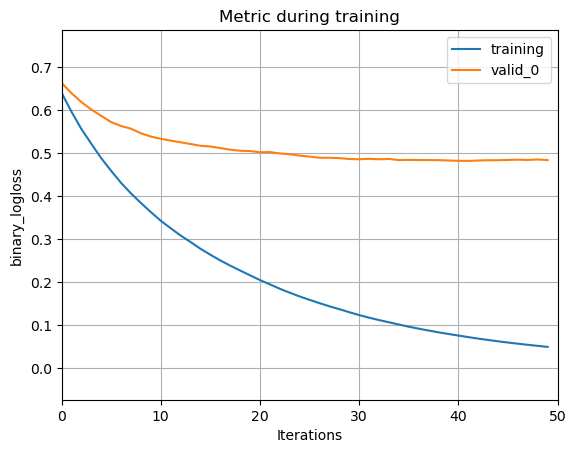

In [15]:
lightgbm.plot_metric(lgb_clf)

In [16]:
'''
# https://panda-clip.com/learning-curve/

train_sizes, train_scores, valid_scores = learning_curve(
                                              linear_model.Ridge(alpha=10),
                                              X=X_train.values, y=y_train,
                                              train_sizes=np.linspace(0.1, 1.0, 10),
                                              cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
'''

'\n# https://panda-clip.com/learning-curve/\n\ntrain_sizes, train_scores, valid_scores = learning_curve(\n                                              linear_model.Ridge(alpha=10),\n                                              X=X_train.values, y=y_train,\n                                              train_sizes=np.linspace(0.1, 1.0, 10),\n                                              cv=5)\n\ntrain_mean = np.mean(train_scores, axis=1)\ntrain_std  = np.std(train_scores, axis=1)\nvalid_mean = np.mean(valid_scores, axis=1)\nvalid_std  = np.std(valid_scores, axis=1)\n'